In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.utils import resample
import shap
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('D:/Downloads/final-year-project/data/preprocessed_train_data.csv')

# Load the Transformer model
transformer_model = tf.keras.models.load_model('models/Transformer_ADAM')

# Filter the data for primary_use==0 & meter==0
#data = data.query('primary_use==0 & meter==0')

# Identify non-numeric columns to exclude (e.g., datetime columns)
non_numeric_columns = ['timestamp']  # Replace with actual column names if different

# Prepare data for model input (excluding non-numeric columns)
expected_feature_count = 12  # Model expects 12 features per time step
all_feature_columns = [col for col in data.columns if col not in non_numeric_columns and col != 'meter_reading' and col != 'Unnamed: 0']

# Subsample the data to balance the feature contributions
data_majority = data[data['square_feet'] <= data['square_feet'].median()]
data_minority = data[data['square_feet'] > data['square_feet'].median()]

# Downsample majority class
data_majority_downsampled = resample(data_majority,
                                     replace=False,    # sample without replacement
                                     n_samples=len(data_minority),     # to match minority class
                                     random_state=123) # reproducible results

# Combine minority class with downsampled majority class
data_balanced = pd.concat([data_majority_downsampled, data_minority])

# Prepare data for model input (excluding non-numeric columns)
feature_columns = all_feature_columns[:expected_feature_count]

X = data_balanced[feature_columns].values.astype(np.float32)
y = data_balanced['meter_reading'].values.astype(np.float32)  # Meter Reading

# Handle NaN values in both X and y
# Remove rows with NaN values in X or y
non_nan_indices = ~np.isnan(y) & ~np.isnan(X).any(axis=1)
X = X[non_nan_indices]
y = y[non_nan_indices]

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (6031694, 12)
Shape of y: (6031694,)


In [2]:
# Define a function to preprocess data into time series format
def create_time_series_data(X, y, time_steps=6):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Prepare time series data
time_steps = 6
X_series, y_series = create_time_series_data(X, y, time_steps)

print("Shape of X_series:", X_series.shape)
print("Shape of y_series:", y_series.shape)

Shape of X_series: (6031688, 6, 12)
Shape of y_series: (6031688,)


In [3]:
# Select a larger subset of the data for SHAP explanation
sample_size = 200  # Increase sample size for better SHAP value estimation
X_sample = X_series[:sample_size]  # Shape (sample_size, time_steps, expected_feature_count)

print("Shape of X_sample:", X_sample.shape)

# Create a function to make predictions with the Transformer model
def model_predict(data):
    # Reshape data to (batch_size, time_steps, features)
    data_reshaped = data.reshape((-1, time_steps, expected_feature_count))
    print("Shape of data in model_predict:", data_reshaped.shape)
    return transformer_model.predict(data_reshaped).flatten()

# Create SHAP explainer for the Transformer model using KernelExplainer
explainer = shap.KernelExplainer(model_predict, X_sample.reshape(sample_size, -1))

print("Explainer prepared")

Shape of X_sample: (200, 6, 12)
Shape of data in model_predict: (200, 6, 12)
7/7 [==============================] - 1s 24ms/step


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Explainer prepared


  0%|          | 0/200 [00:00<?, ?it/s]

Shape of data in model_predict: (1, 6, 12)
1/1 [==============================] - 0s 17ms/step
Shape of data in model_predict: (438400, 6, 12)
13700/13700 [==============================] - 434s 32ms/step
Shape of data in model_predict: (1, 6, 12)
1/1 [==============================] - 0s 19ms/step
Shape of data in model_predict: (438400, 6, 12)
13700/13700 [==============================] - 490s 36ms/step
Shape of data in model_predict: (1, 6, 12)
1/1 [==============================] - 0s 21ms/step
Shape of data in model_predict: (438400, 6, 12)
13700/13700 [==============================] - 517s 38ms/step
Shape of data in model_predict: (1, 6, 12)
1/1 [==============================] - 0s 19ms/step
Shape of data in model_predict: (438400, 6, 12)
13700/13700 [==============================] - 488s 36ms/step
Shape of data in model_predict: (1, 6, 12)
1/1 [==============================] - 0s 20ms/step
Shape of data in model_predict: (438400, 6, 12)
13700/13700 [========================

IndexError: list index out of range

<Figure size 640x480 with 0 Axes>

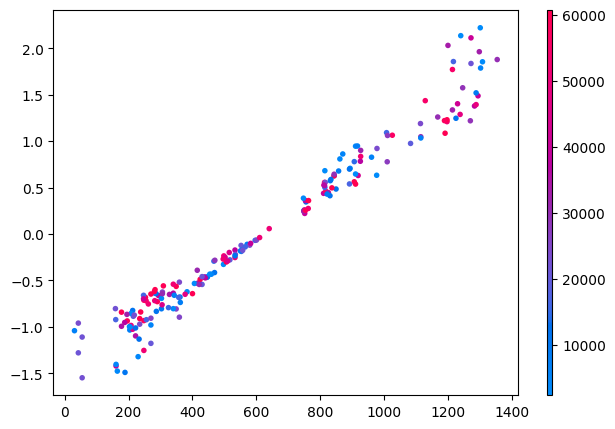

In [4]:
# Generate SHAP values for the selected instances
shap_values = explainer.shap_values(X_sample.reshape(sample_size, -1))

print("Shape of SHAP values:", np.array(shap_values).shape)

# Reshape SHAP values to original time-series format if needed
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# Plot SHAP dependence plots for each feature
for i, feature in enumerate(feature_columns):
    plt.figure()
    shap.dependence_plot(i, shap_values, X_sample.reshape(sample_size, -1), feature_names=feature_columns)
    plt.title(f'SHAP Dependence Plot for {feature}')
    plt.show()

In [13]:
import numpy as np

# Assuming shap_values is a numpy array
np.save('shap_values.npy', shap_values)  # Saves the SHAP values as a .npy file


Shape of SHAP values: (200, 72)
Number of features in SHAP values: 72
Number of feature columns: 12


IndexError: list index out of range

<Figure size 640x480 with 0 Axes>

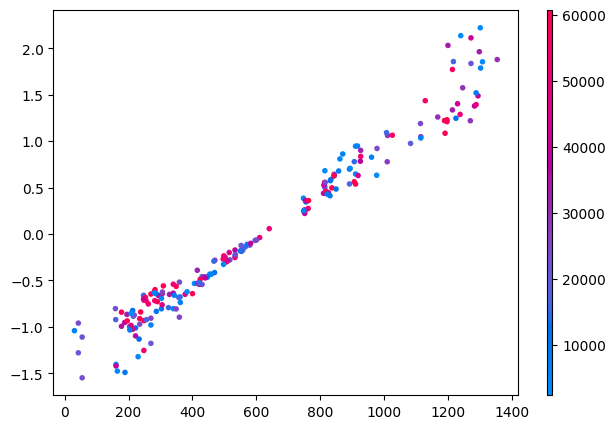

In [6]:
import shap
import matplotlib.pyplot as plt

# Print the shape of SHAP values
print("Shape of SHAP values:", np.array(shap_values).shape)

# Reshape SHAP values to original time-series format if needed
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# Print the number of features in SHAP values
num_features_in_shap = shap_values.shape[1]
print(f'Number of features in SHAP values: {num_features_in_shap}')
print(f'Number of feature columns: {len(feature_columns)}')

# Ensure the loop does not exceed the number of features in shap_values
for i in range(min(num_features_in_shap, len(feature_columns))):
    feature = feature_columns[i]
    plt.figure()
    shap.dependence_plot(i, shap_values, X_sample.reshape(sample_size, -1), feature_names=feature_columns)
    plt.title(f'SHAP Dependence Plot for {feature}')
    plt.savefig(f'SHAP_Dependence_Plot_{feature}.png')  # Save the plot locally
    plt.show()


Shape of SHAP values: (200, 72)
Number of features in SHAP values: 72
Number of feature columns: 12
Plotting feature 0: building_id
Error plotting feature 0: building_id - list index out of range
Plotting feature 1: meter
Error plotting feature 1: meter - list index out of range
Plotting feature 2: site_id
Error plotting feature 2: site_id - list index out of range
Plotting feature 3: primary_use
Error plotting feature 3: primary_use - list index out of range
Plotting feature 4: square_feet


<Figure size 640x480 with 0 Axes>

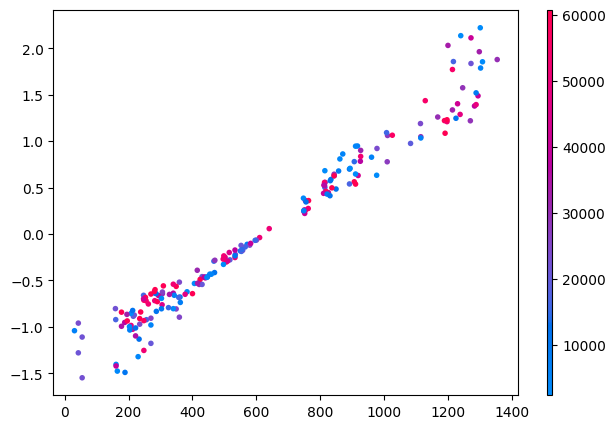

<Figure size 640x480 with 0 Axes>

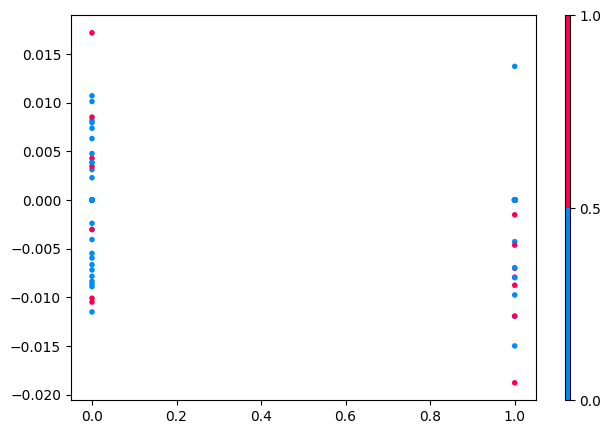

<Figure size 640x480 with 0 Axes>

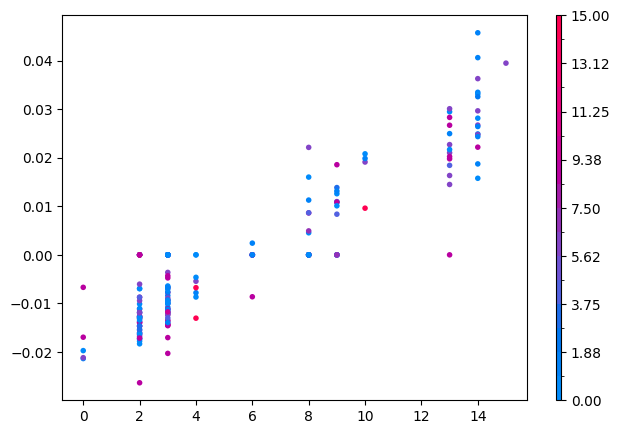

<Figure size 640x480 with 0 Axes>

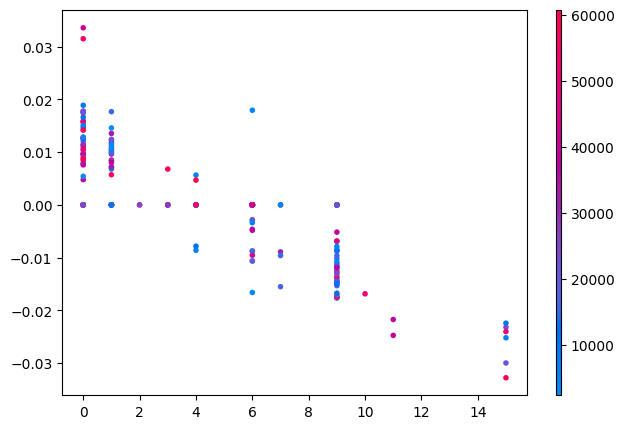

<Figure size 640x480 with 0 Axes>

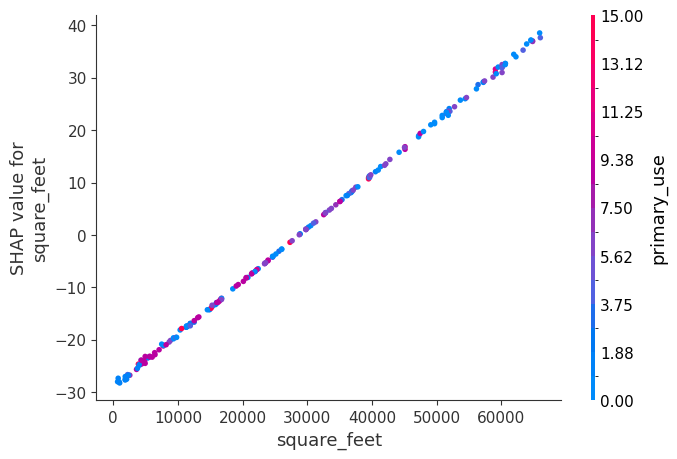

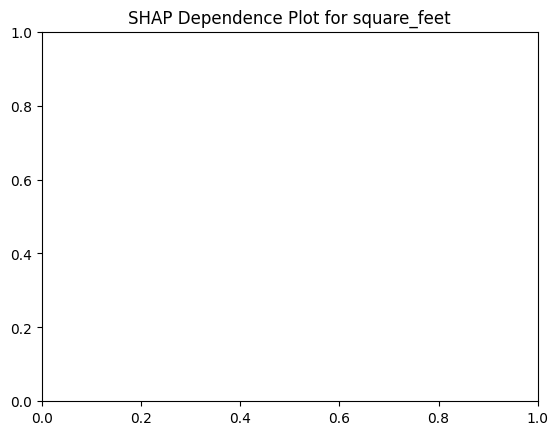

Plotting feature 5: air_temperature
Error plotting feature 5: air_temperature - list index out of range
Plotting feature 6: cloud_coverage


<Figure size 640x480 with 0 Axes>

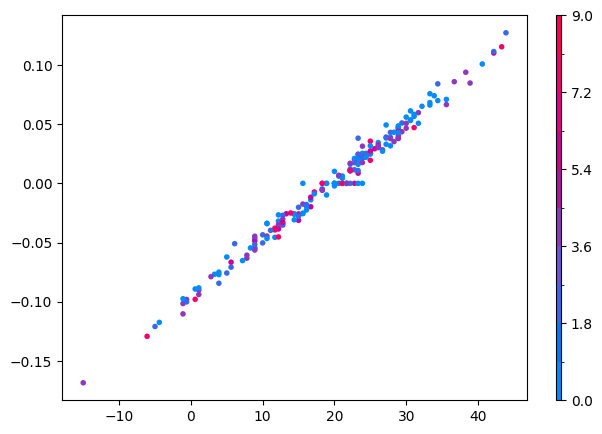

<Figure size 640x480 with 0 Axes>

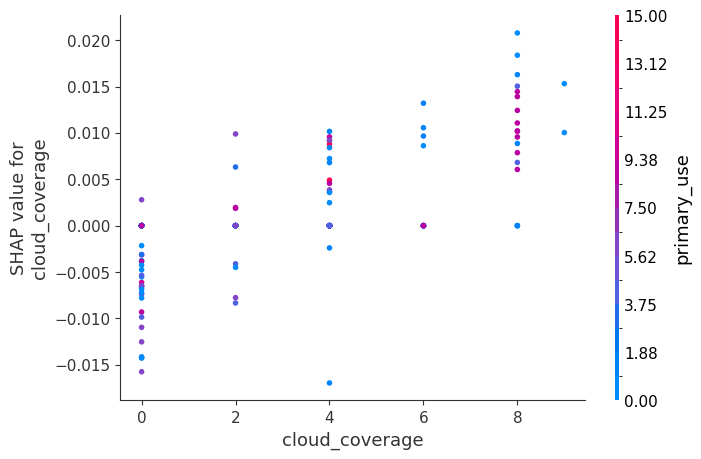

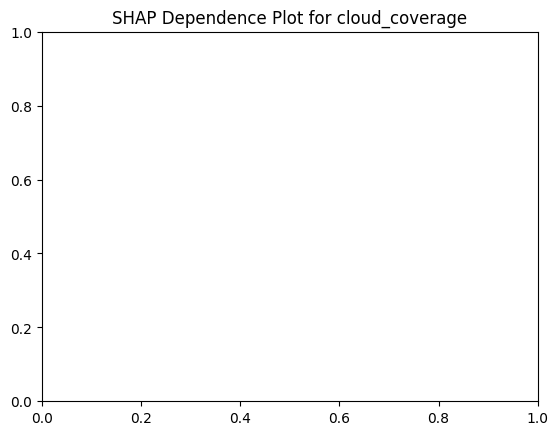

Plotting feature 7: dew_temperature


<Figure size 640x480 with 0 Axes>

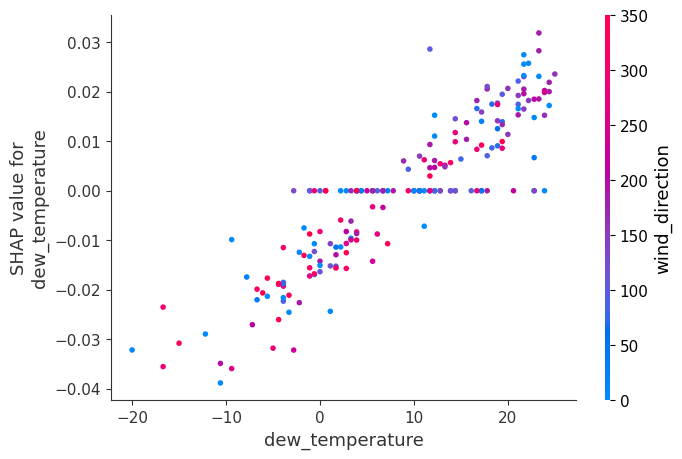

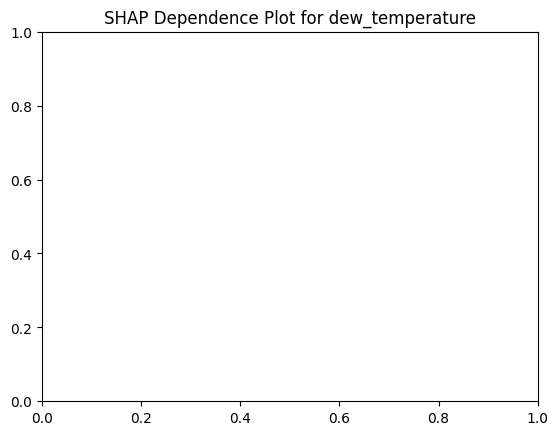

Plotting feature 8: precip_depth_1_hr
Error plotting feature 8: precip_depth_1_hr - list index out of range
Plotting feature 9: sea_level_pressure
Error plotting feature 9: sea_level_pressure - list index out of range
Plotting feature 10: wind_direction
Error plotting feature 10: wind_direction - list index out of range
Plotting feature 11: wind_speed
Error plotting feature 11: wind_speed - list index out of range
SHAP dependence plots have been saved locally.


<Figure size 640x480 with 0 Axes>

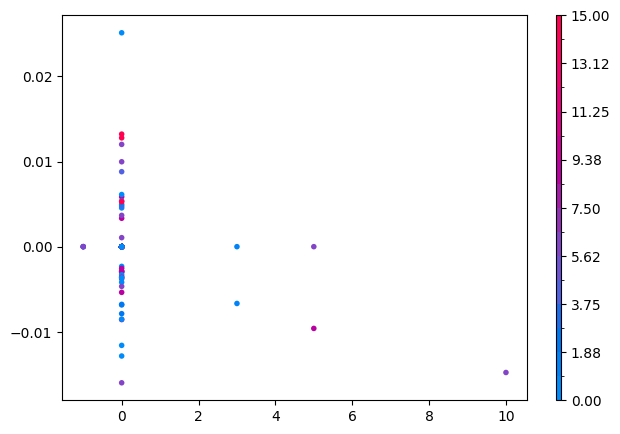

<Figure size 640x480 with 0 Axes>

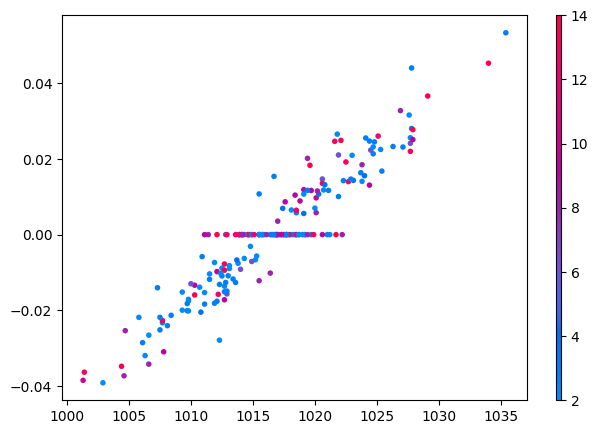

<Figure size 640x480 with 0 Axes>

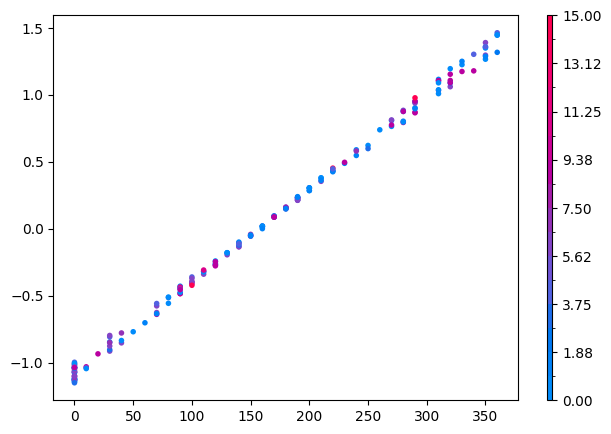

<Figure size 640x480 with 0 Axes>

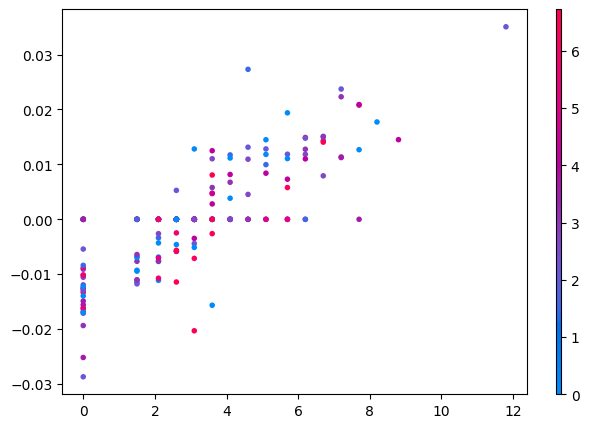

In [8]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# Print the shape of SHAP values
print("Shape of SHAP values:", np.array(shap_values).shape)

# Reshape SHAP values to original time-series format if needed
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# Print the dimensions and check for consistency
num_features_in_shap = shap_values.shape[1] if len(shap_values.shape) > 1 else len(shap_values)
num_feature_columns = len(feature_columns)
print(f'Number of features in SHAP values: {num_features_in_shap}')
print(f'Number of feature columns: {num_feature_columns}')

# Ensure the loop does not exceed the number of features in shap_values
for i in range(min(num_features_in_shap, num_feature_columns)):
    feature = feature_columns[i]
    try:
        print(f"Plotting feature {i}: {feature}")  # Debug print
        plt.figure()
        shap.dependence_plot(i, shap_values, X_sample.reshape(sample_size, -1), feature_names=feature_columns)
        plt.title(f'SHAP Dependence Plot for {feature}')
        plt.savefig(f'SHAP_Dependence_Plot_{feature}.png')  # Save the plot locally
        plt.show()
    except Exception as e:
        print(f"Error plotting feature {i}: {feature} - {e}")

print("SHAP dependence plots have been saved locally.")


Shape of SHAP values: (200, 72)
Number of features in SHAP values: 72
Number of feature columns: 12
Plotting feature 0: building_id
'.'


<Figure size 640x480 with 0 Axes>

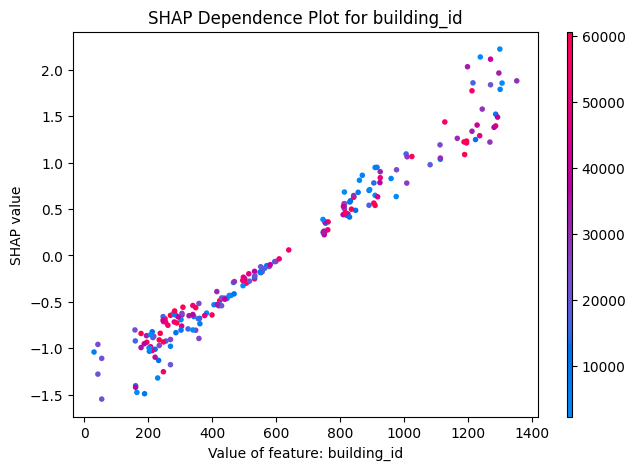

Plotting feature 1: meter
'.'


<Figure size 640x480 with 0 Axes>

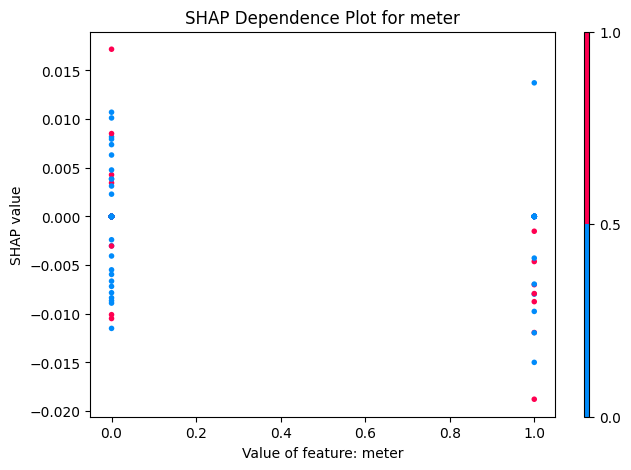

Plotting feature 2: site_id
'.'


<Figure size 640x480 with 0 Axes>

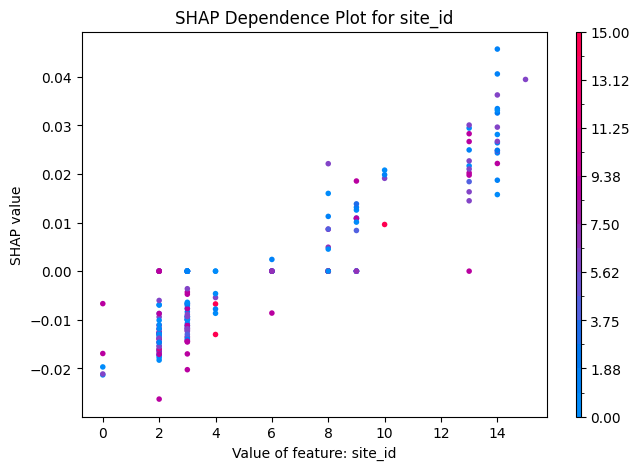

Plotting feature 3: primary_use
'.'


<Figure size 640x480 with 0 Axes>

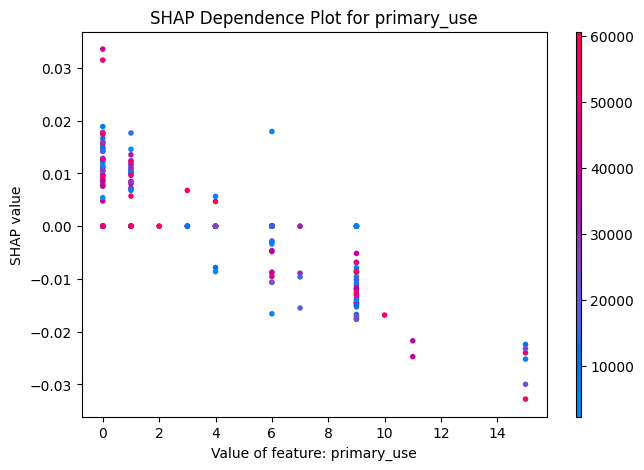

Plotting feature 4: square_feet


<Figure size 640x480 with 0 Axes>

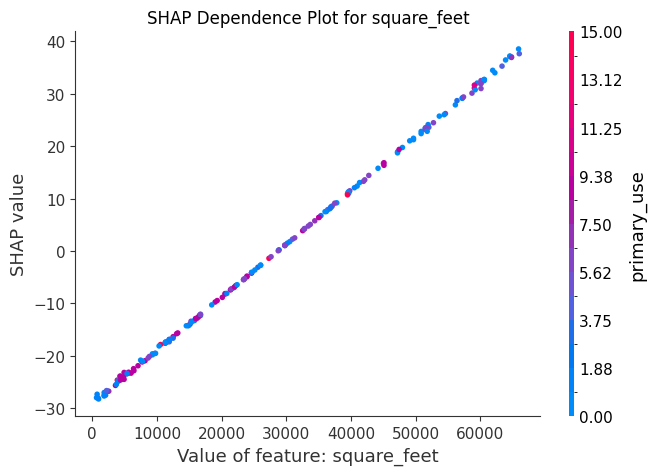

Plotting feature 5: air_temperature
'.'


<Figure size 640x480 with 0 Axes>

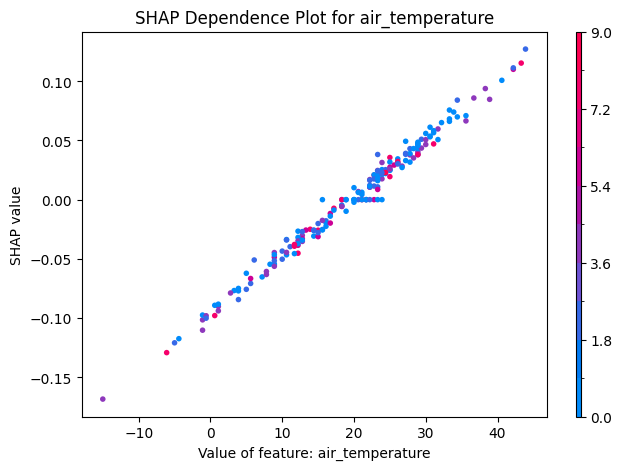

Plotting feature 6: cloud_coverage


<Figure size 640x480 with 0 Axes>

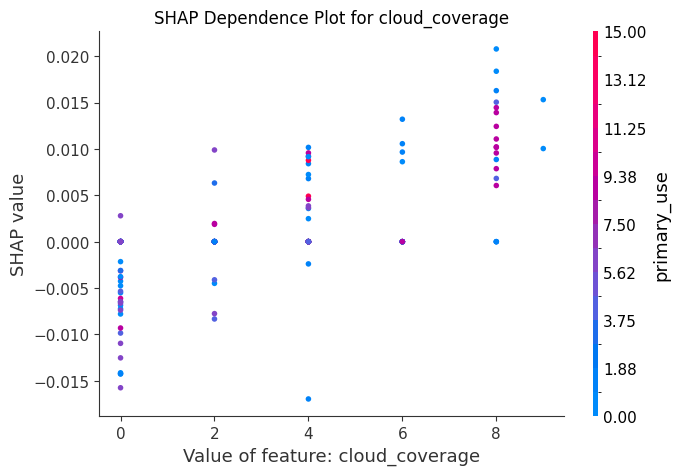

Plotting feature 7: dew_temperature


<Figure size 640x480 with 0 Axes>

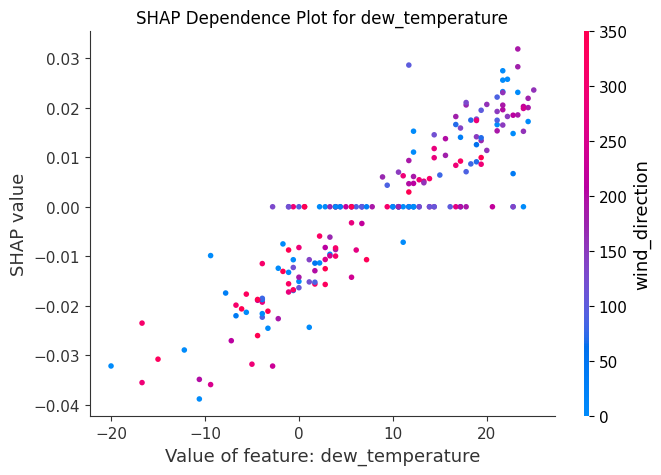

Plotting feature 8: precip_depth_1_hr
'.'


<Figure size 640x480 with 0 Axes>

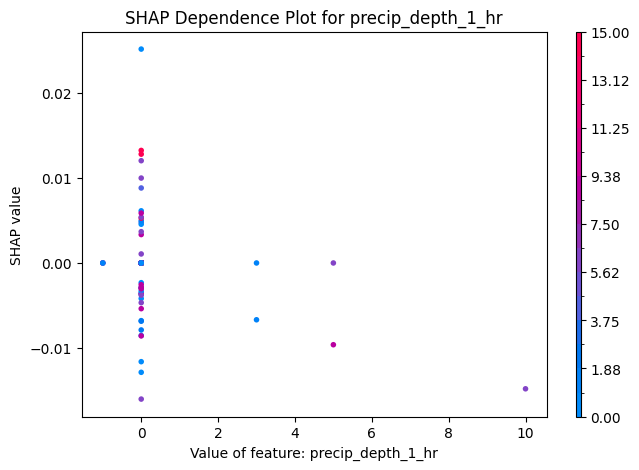

Plotting feature 9: sea_level_pressure
'.'


<Figure size 640x480 with 0 Axes>

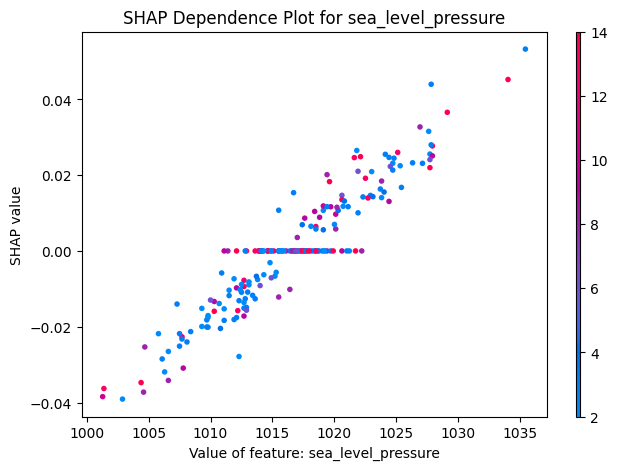

Plotting feature 10: wind_direction
'.'


<Figure size 640x480 with 0 Axes>

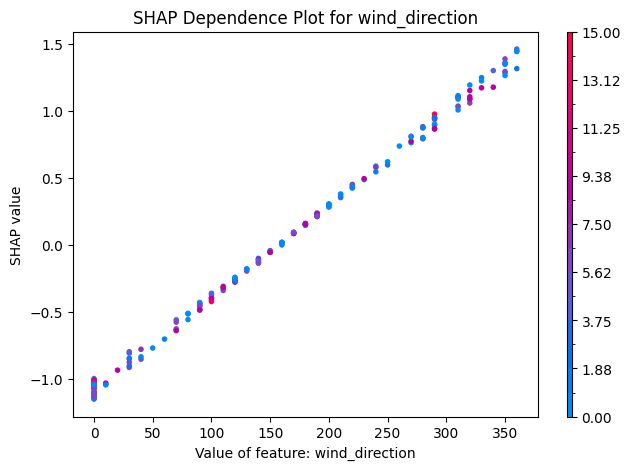

Plotting feature 11: wind_speed
'.'


<Figure size 640x480 with 0 Axes>

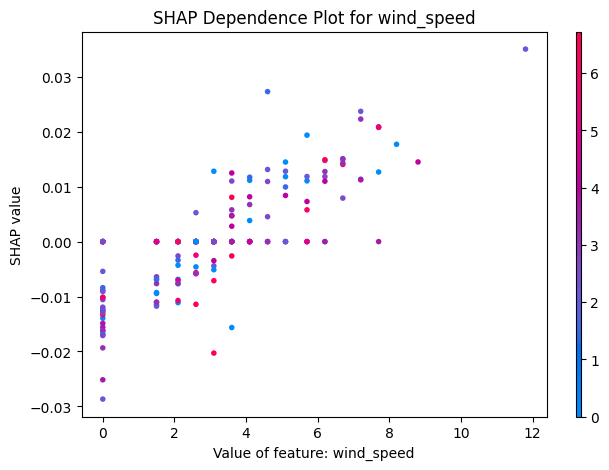

SHAP dependence plots for features up to index 11 have been saved locally.


In [20]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# Assume shap_values and X_sample are defined
shap_values = np.array(shap_values)
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# Print the shape of SHAP values
print("Shape of SHAP values:", shap_values.shape)

# Check dimensions for consistency
num_features_in_shap = shap_values.shape[1] if len(shap_values.shape) > 1 else len(shap_values)
print(f'Number of features in SHAP values: {num_features_in_shap}')
print(f'Number of feature columns: {len(feature_columns)}')

# Limit the loop to feature 12 (index 11)
max_features_to_plot = min(12, num_features_in_shap, len(feature_columns))

for i in range(max_features_to_plot):
    plt.figure()
    feature = feature_columns[i]  # Feature name from feature_columns list
    try:
        print(f"Plotting feature {i}: {feature}")  # Debug print for tracking
        shap.dependence_plot(i, shap_values, X_sample.reshape(-1, num_features_in_shap), feature_names=feature_columns, show=False)
    except Exception as e:
        print(f"'.'")  # Error message
    finally:
        # Adding axis labels and title in all cases
        plt.xlabel(f'Value of feature: {feature}')
        plt.ylabel('SHAP value')
        plt.title(f'SHAP Dependence Plot for {feature}')
        # Save the plot locally regardless of success or error
        plt.savefig(f'SHAP_Dependence_Plot_{feature}.png')
        plt.show()

print("SHAP dependence plots for features up to index 11 have been saved locally.")
